In [1]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
num_sites = 3
for i in range(num_sites):
    print(i)

0
1
2


In [3]:
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

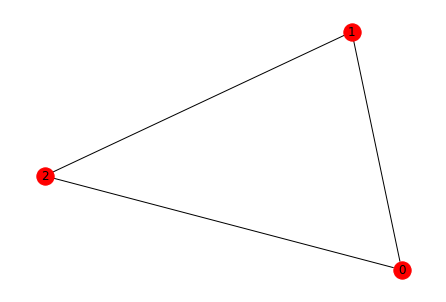

In [4]:
# Kagome unit cell
num_sites = 3
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 0, t)]

# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'red', 'with_labels':True})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [5]:
# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [7]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No single site external field
)

print(heis.second_q_ops().simplify())

  Z_1 Z_2 * (1+0j)
+ Z_0 Z_2 * (1+0j)
+ Z_0 Z_1 * (1+0j)
+ Y_1 Y_2 * (1+0j)
+ Y_0 Y_2 * (1+0j)
+ Y_0 Y_1 * (1+0j)
+ X_1 X_2 * (1+0j)
+ X_0 X_2 * (1+0j)
+ X_0 X_1 * (1+0j)


In [8]:
# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4*log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZZI', 'ZIZ', 'IZZ', 'YYI', 'YIY', 'IYY', 'XXI', 'XIX', 'IXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [9]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

[-3. -3. -3.]


In [10]:
# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)
print(gs_energy)

-3.0


In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [12]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account

# TOKEN='55e2df6536e204c8a32fde954a4936945598573d6bbc08eeb38f2479e791aa66bea18252ca378bf445189a9d6deace7c734c7703753c9540ab663ad7ff16a299'
# IBMQ.save_account(TOKEN)

provider = IBMQ.load_account()


In [13]:
IBMQ.providers()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# Real backend; needed for transpilation later on
# guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
# from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
# noisy_sim = FakeGuadalupe()

In [14]:
# guadalupe = provider.get_backend("ibmq_guadalupe")
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [15]:
# Real backend; needed for transpilation later on
nairobi = provider.get_backend("ibm_nairobi")

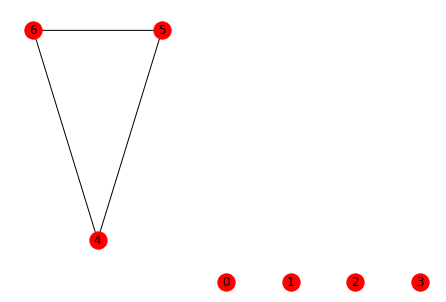

In [16]:
# Kagome unit cell
num_qubits = 7
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_7 = rx.PyGraph(multigraph=False)
graph_7.add_nodes_from(range(num_qubits))
edge_list = [
    (4, 5, t),
    (5, 6, t),
    (6, 4, t)]

# Generate graph from the list of edges
graph_7.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_7 = Lattice(graph_7)

# Draw Lattice
kagome_pos = {0:[1,-1.2], 1:[1.5, -1.2], 2:[2, -1.2], 3:[2.5, -1.2],
              4:[0,-1],
              5:[0.5,0], 
              6:[-0.5,0]}
kagome_unit_cell_7.draw(style={'node_color':'red', 'with_labels':True, 'pos':kagome_pos})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [17]:
# Build Hamiltonian from graph edges
heis_7 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_7,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_7 = 4 * log_mapper.map(heis_7.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 9 ZZ, 9 YY, and 9 XX terms over 7 qubits instead of over 6 qubits
ham_7

PauliSumOp(SparsePauliOp(['ZZIIIII', 'ZIZIIII', 'IZZIIII', 'YYIIIII', 'YIYIIII', 'IYYIIII', 'XXIIIII', 'XIXIIII', 'IXXIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [18]:
from qiskit.circuit.library import EfficientSU2

In [19]:
# Construct ansatz from qiskit circuit library functions
# See docs for full details
ansatz = EfficientSU2(3, entanglement='full', reps=4, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌──────────┐          ┌──────────┐┌──────────┐                       ┌───────────┐┌───────────┐                       ┌───────────┐┌───────────┐                            
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──■────■──┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├───────────────■────■──┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├───────────────■────■──┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├───────────────■────■───────
     ├──────────┤├──────────┤┌─┴─┐  │  └──────────┘├──────────┤┌───────────┐┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │  └───────────┘├───────────┤┌───────────┐┌─┴─┐  │       
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├┤ X ├──┼───────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├┤ X ├──┼────────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├┤ X ├──┼────────■──────┤ Ry(θ[19]) ├┤ Rz(θ[22]) ├┤ X ├──┼────■──
     ├──────────┤├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐    ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐┌─┴─┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─────┤ X ├────┤ X ├────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├─────┤ X ├────┤ X ├────┤ Ry(θ[20]) ├┤ Rz(θ[23]) ├─────┤ X ├┤ X ├
     └──────────┘└──────────┘     └───┘   └───┘    └──────────┘└───────────┘     └───┘    └───┘    └───────────┘└───────────┘     └───┘    └───┘    └───────────┘└───────────┘     └───┘└───┘

In [20]:
# # Build a custom ansatz from scratch
# ansatz_custom = QuantumCircuit(3)
# # build initial state

# ansatz_custom.h(0)
# ansatz_custom.h(2)
# ansatz_custom.cx(0,1)

# # First layer
# j = 0
# for i in range(3):
#     ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#     j += 1
#     ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#     j += 1
    
# ansatz_custom.cx(range(0, 2), range(1, 3))

# ansatz_custom.draw(fold=250)

┌───┐           ┌─────────┐┌─────────┐          
q_0: ┤ H ├─────■─────┤ Rz(θ_0) ├┤ Ry(θ_1) ├──■───────
     └───┘   ┌─┴─┐   ├─────────┤├─────────┤┌─┴─┐     
q_1: ────────┤ X ├───┤ Rz(θ_2) ├┤ Ry(θ_3) ├┤ X ├──■──
     ┌───┐┌──┴───┴──┐├─────────┤└─────────┘└───┘┌─┴─┐
q_2: ┤ H ├┤ Rz(θ_4) ├┤ Ry(θ_5) ├────────────────┤ X ├
     └───┘└─────────┘└─────────┘                └───┘

In [67]:
import math

#Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(3)

ansatz_custom.rx(Parameter('θ_0'), 0)
ansatz_custom.rx(Parameter('θ_1'), 1)
ansatz_custom.rx(Parameter('θ_2'), 2)

ansatz_custom.cx(1,0)
ansatz_custom.ry(Parameter('θ_3')+math.pi/2,1)
ansatz_custom.z(1)
ansatz_custom.cx(0,1)

ansatz_custom.cx(2,1)
ansatz_custom.ry(Parameter('θ_4')+math.pi/2,2)
ansatz_custom.z(2)
ansatz_custom.cx(1,2)

ansatz_custom.draw(fold=250)

┌─────────┐┌───┐                                                           
q_0: ┤ Rx(θ_0) ├┤ X ├────────────────────────■──────────────────────────────────
     ├─────────┤└─┬─┘┌───────────────┐┌───┐┌─┴─┐┌───┐                           
q_1: ┤ Rx(θ_1) ├──■──┤ Ry(θ_3 + π/2) ├┤ Z ├┤ X ├┤ X ├────────────────────────■──
     ├─────────┤     └───────────────┘└───┘└───┘└─┬─┘┌───────────────┐┌───┐┌─┴─┐
q_2: ┤ Rx(θ_2) ├──────────────────────────────────■──┤ Ry(θ_4 + π/2) ├┤ Z ├┤ X ├
     └─────────┘                                     └───────────────┘└───┘└───┘

In [68]:
q_layout = [4, 5, 6]
ansatz_opt = transpile(ansatz_custom, backend=nairobi, initial_layout=q_layout)

In [69]:
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 11), ('sx', 10), ('cx', 4)])
number of parameters in the circuit: 5


global phase: π/2
                                                                                                                                                 
ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                 
ancilla_1 -> 1 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                 
ancilla_2 -> 2 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                 
ancilla_3 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌─────────┐┌────┐┌─────────────┐┌────┐┌──────────┐┌───┐                                                                           
      q_0 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ_0 + π) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├────────────────────────────────■──────────────────────────────────────────
               ├─────────┤├────┤├─────────────┤├────┤├──────────┤└─┬─┘┌────┐┌────────────────┐┌────┐┌─┴─┐┌───┐                                   
      q_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ_1 + π) ├┤ √X ├┤ Rz(5π/2) ├──■──┤ √X ├┤ Rz(θ_3 + 3π/2) ├┤ √X ├┤ X ├┤ X ├────────────────────────────────■──
               ├─────────┤├────┤├─────────────┤├────┤├──────────┤     └────┘└────────────────┘└────┘└───┘└─┬─┘┌────┐┌────────────────┐┌────┐┌─┴─┐
      q_2 -> 6 ┤ Rz(π/2) ├┤ √X ├┤ Rz(θ_2 + π) ├┤ √X ├┤ Rz(5π/2) ├──────────────────────────────────────────■──┤ √X ├┤ Rz(θ_4 + 3π/2) ├┤ √X ├┤ X ├
               └─────────┘└────┘└─────────────┘└────┘└──────────┘                                             └────┘└────────────────┘└────┘└───┘

In [70]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=3000)

In [71]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [72]:
# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [73]:
from qiskit.primitives import Estimator

In [74]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_7])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_7)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 6000,
    'eigenstate': None,
    'eigenvalue': -3.0,
    'optimal_circuit': None,
    'optimal_parameters': array([ 1.68208154e-01,  2.21551079e-13,  2.23793417e-13, -1.12303232e-14,
        1.57079633e+00]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 10.88


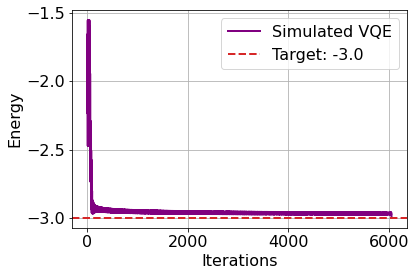

In [75]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

In [ ]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

In [ ]:
# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk

# TOKEN='55e2df6536e204c8a32fde954a4936945598573d6bbc08eeb38f2479e791aa66bea18252ca378bf445189a9d6deace7c734c7703753c9540ab663ad7ff16a299'

# QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN)

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [ ]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

In [ ]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_7)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum')
print('Simulators:', service.backends())

In [ ]:
backend = 'ibm_nairobi'

In [ ]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_7)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

In [ ]:
#run using FakeGuadalupe - see kagome-vqe-practice-2-FakeGuadalupe notebook

In [ ]:
#run using FakeGuadalupeV2 - see kagome-vqe-practice-3-FakeGuadalupev2 notebook

In [ ]:
#run using a newly generated simulator for ibmq_guadalupe - see kagome-vqe-practice-4-latestFakeGuadalupe notebook

#this cannot be done as generating the most recent snapshot for even the real machine seems to require access to the real machine

#in other words, ibmq_guadalupe should come in the list of my available backends before I can pass it to the AerSimulator to generate its corresponding fake backend using the most recent calibration results

#this is all if I understood things correctly

#for more on fake backend providers and how to generate the corresponding fake backend corresponding to the most recent calibration results, see: https://qiskit.org/documentation/apidoc/providers_fake_provider.html